In [96]:
# import web driver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from seleniumrequests import Chrome

from bs4 import BeautifulSoup
import requests
import time
import random
import re
import getpass
import os
import pandas as pd
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Crime Data - Clean and Aggregate

#### Clean Crime Data and Save to 'chicago_crime_cleaned_aggregated.csv'

In [2]:
# # Preprocessing Chicago Crime Data

# # Import Chicago Crime Data : Source : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
# df_crime = pd.read_csv("chicago_crime.csv")

# # Convert text date to datetime
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['Date'],format="%m/%d/%Y %I:%M:%S %p", errors = 'coerce')

# # Strip hr, min, sec data so that aggregation per day is possible
# df_crime['DATE_TIME_TRUN'] = df_crime['DATE_TIME'].map(lambda x: x.strftime('%Y-%m-%d'))

# # Drop unneeded columns
# df_crime = df_crime[['ID','DATE_TIME_TRUN']].copy()

# # Just get the date and total crime count and create new df after aggregating by single day
# df_crime = df_crime.groupby(['DATE_TIME_TRUN'],as_index = False).count().copy()

# # Save cleaned data
# with open('chicago_crime_cleaned_aggregated.pkl', 'wb') as picklefile:
#     pickle.dump(df_crime, picklefile)


#### Load Cleaned & Aggregated Crime Data and Few More Tweaking

In [3]:
# # Load data
# with open('chicago_crime_cleaned_aggregated.pkl', 'rb') as picklefile: 
#     df_crime = pickle.load(picklefile)

# # Turn DATE_TIME back to datetime dtype
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['DATE_TIME_TRUN'])
# df_crime['YEAR_MONTH'] = df_crime['DATE_TIME_TRUN'].apply(lambda x:x[:-3])

# # Remove Crime Data Outside Available Weather Data
# df_crime = df_crime[df_crime['DATE_TIME_TRUN']>'2009-09-01'] 

# # Rename Columns to Make Them More Intuitive and for Later Merging with Weather Data
# df_crime.rename(columns={'ID':'CRIME_COUNT','DATE_TIME':'DATE_TIME_PROCESSED'}, inplace=True)

# Weather Data -  Scraping

#### (Testing) scroll length 

In [4]:
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(2,2010)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

#### Web scraping function

In [5]:
def scrape_weather_url(url):
    # weather data holder to be inserted to pandas dataframe
    high_low, weather_desc, humidity_barometer, wind, date_time = [], [], [], [], []
    
    # open url
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, "lxml")
    days_chain = [x.find_all('a') for x in soup.find_all(class_='weatherLinks')]
    time.sleep(5)
    
    # Load Entire Page by Scrolling to charts
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight/3.5);") # Scroll down to bottom
    
    # First load of each month takes extra long time. Therefore 'counter' variable is used to run else block first
    counter = 0
    for ix,link in enumerate(days_chain[0]):
        
        '''
        Bottom section tries to solve loading issue by implementing wait feature
        Refer : https://selenium-python.readthedocs.io/waits.html
        '''
        wait = WebDriverWait(driver, 10)
        if counter!=0:
            delay = 3 # seconds
            try:
                myElem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
            except TimeoutException:
                print("Loading took too much time!" ) 
            day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
            wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
            day_link.click()
        else:
            delay = 5 # seconds
            try:
                myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
            except TimeoutException:
                print("Loading took too much time!" ) 
            day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
            wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
            time.sleep(4)
            day_link.click()
            time.sleep(3)
            counter+=1
        
        # Wait a bit for the Javascript to fully load data to be scraped
        time.sleep(2.5)
            
        # Scrape weather data
        high_low.insert(0,driver.find_elements_by_xpath("//div[@class='temp']")[-1].text) #notice elements, s at the end. This returns a list, and I can index it.
        weather_desc.insert(0,driver.find_element_by_xpath("//div[@class='wdesc']").text)
        humidity_barometer.insert(0,driver.find_element_by_xpath("//div[@class='mid__block']").text)
        wind.insert(0,driver.find_element_by_xpath("//div[@class='right__block']").text)
        date_time.insert(0,driver.find_elements_by_xpath("//div[@class='date']")[-1].text)
    return high_low, weather_desc, humidity_barometer, wind, date_time

 

#### Iterate through entire list of month&year combo. Remove month&year already scraped from list

In [6]:
# # Initiate Selenium Chrome driver for Mac
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())

# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]

# # remove done items from list of month & year combo that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)

# # iterate through each year & month combo to scrape
# for date in year_month_list_done_removed:
#     # define initial empty dataframe
#     df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})
#     month = int(date[5:])
#     year = date[:4]
#     url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(month,year)
#     high_low, weather_desc, humidity_barometer, wind, date_time = scrape_weather_url(url)
#     df_weather_holder = pd.DataFrame({'DATE_TIME':date_time, 'HIGH_LOW':high_low, 'WEATHER_DESC':weather_desc,'HUMIDITY_BAROMETER':humidity_barometer,'WIND':wind})
#     df_weather = df_weather.append(df_weather_holder)
#     df_weather.to_csv('weather_data/df_weather_{}_{}.csv'.format(month,year),index=False)
    

#### (Troubleshooting) For particular month&year, print scraped data's dataframe and open weather site for comparison

In [72]:
# read_index = 0

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())
# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]
# # remove done items from list of month & year combe that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)
# # Open weather site for that month
# read_month = [x[11:][:-4].split('_') for x in done_list][read_index][0]
# read_year = [x[11:][:-4].split('_') for x in done_list][read_index][1]
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(read_month,read_year)
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

# Weather Data - Clean

#### Clean Weather Data and Save to 'df_weather_clean.csv'

In [7]:
# # Obtain scraped data files per month
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')

# # Initiate empty dataframe for weather data to compile individual files
# df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})

# # Concat all individual files
# for file_name in done_list:
#     file = pd.read_csv('weather_data/'+file_name)
#     df_weather = pd.concat([df_weather,file],ignore_index=True,axis=0)

# # Remove duplicate rows. (Mistake created by earlier code imperfection that was corrected later)
# df_weather.drop_duplicates(inplace=True)

# # Process and create new columns with individual features for further feature engineering
# df_weather['DATE_TIME_PROCESSED'] = df_weather['DATE_TIME'].apply(lambda x : x.split(',')[1]+x.split(',')[2])
# df_weather['DATE_TIME_PROCESSED'] = pd.to_datetime(df_weather['DATE_TIME_PROCESSED'], format = ' %B %d %Y')
# df_weather['T_HIGH_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[0].strip())
# df_weather['T_LOW_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[1].strip().split()[0])
# df_weather['HUMIDITY_%'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[1][:-1])
# df_weather['BAROMETER_HG'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[3])
# df_weather['WIND_DIRECTION'] = df_weather['WIND'].apply(lambda x : x.split()[0])
# df_weather['WIND_MPH'] = df_weather['WIND'].apply(lambda x : x.split()[2])

# # Drop raw columns that contained multiple featuers as texts
# df_weather_processed = df_weather.drop(['DATE_TIME', 'HIGH_LOW','HUMIDITY_BAROMETER', 'WIND'], axis=1)

# # Remove rows for which weather data was not available
# df_weather_processed = df_weather_processed[df_weather_processed['T_HIGH_F']!='N']

# # Turn object dtypes to floats for temperatures, humidity, barometer reading, and wind intensity. 
# convert_to_int_list = ['T_LOW_F','T_HIGH_F','HUMIDITY_%','BAROMETER_HG','WIND_MPH']
# for feature in convert_to_int_list:
#         df_weather_processed[feature] = df_weather_processed[feature].astype(float)

# # Save clean data
# with open('df_weather_clean.pkl', 'wb') as picklefile:
#     pickle.dump(df_weather_processed, picklefile)

#### Read from Saved 'df_weather_clean.pkl'

In [8]:
# # Read the saved file.
# with open('df_weather_clean.pkl', 'rb') as picklefile: 
#     df_weather_processed = pickle.load(picklefile)

# Crime & Weather Data - Merge

#### Merge Crime and Weather Data and Save to 'df_merged.csv'

In [70]:
# # Perform merging to df_weather based on date.
# df_merged = pd.merge(df_weather_processed,df_crime,on='DATE_TIME_PROCESSED',how='left')

# # Drop two columns from df_crime that we don't need
# df_merged = df_merged.drop(['DATE_TIME_TRUN','YEAR_MONTH'],axis=1)

# # Drop NaN values. These are values from df_crime that didn't have data  matching for df_weather. Only first 6 rows removed.
# df_merged = df_merged.dropna()

# # # Save df_merged.pkl
# with open('df_merged.pkl', 'wb') as picklefile:
#     pickle.dump(df_merged, picklefile)

#### Read from Saved 'df_merged.csv'

In [78]:
# Read saved df_merged.pkl
with open('df_merged.pkl', 'rb') as picklefile: 
    df_merged = pickle.load(picklefile)

# Feature Engineering - Numeric

In [79]:
# Difference in High and Low Temperature.
# Assumption : Bigger temperature swing -> Bother people more
df_merged['T_DELTA'] = df_merged['T_HIGH_F'] - df_merged['T_LOW_F']

# Day of the week
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['DAY_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.day_name())

# Moving Average for Each Feature
# Assumption : If it has been consistently hot and/or humid, it might contribute to higher crimes because people are more hot-headed



# Feature Engineering - Categorical

In [80]:
# Add "DAY_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['DAY_NAME'], drop_first=False)], axis=1)

# # Add "WIND_DIRECTION" categorical feature as numeric features for linear regression
# df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WIND_DIRECTION'], drop_first=False)], axis=1)

# Convert 'WEATHER_DESC' that's less than 84 occurences to 'Others'
weather_desc_count = df_merged['WEATHER_DESC'].value_counts()
other_weather_desc_count = list(weather_desc_count[weather_desc_count <= 84].index)
df_merged['WEATHER_DESC'] = df_merged['WEATHER_DESC'].replace(other_weather_desc_count, 'Other')

# Add "WEATHER_DESC" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WEATHER_DESC'], drop_first=False)], axis=1)

# Drop catagorical columns
df_merged = df_merged.drop(['WEATHER_DESC', 'DATE_TIME_PROCESSED','WIND_DIRECTION','DAY_NAME'], axis=1)

In [81]:
df_merged.head()

,T_HIGH_F,T_LOW_F,HUMIDITY_%,BAROMETER_HG,WIND_MPH,CRIME_COUNT,T_DELTA,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Clear.,Fog.,Mostly cloudy.,Other,Overcast.,Passing clouds.
6,82.0,66.0,65.0,29.85,12.428,751.0,16.0,0,0,0,0,0,1,0,0,0,0,0,0,1
7,66.0,63.0,84.0,29.77,6.836,751.0,3.0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,72.0,72.0,93.0,29.63,8.700,770.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1
9,73.0,66.0,72.0,29.96,8.078,784.0,7.0,0,0,0,1,0,0,0,0,0,1,0,0,0
10,63.0,63.0,69.0,29.97,6.836,786.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [84]:
list(df_merged.columns)[0:7]

['T_HIGH_F',
 'T_LOW_F',
 'HUMIDITY_%',
 'BAROMETER_HG',
 'WIND_MPH',
 'CRIME_COUNT',
 'T_DELTA']

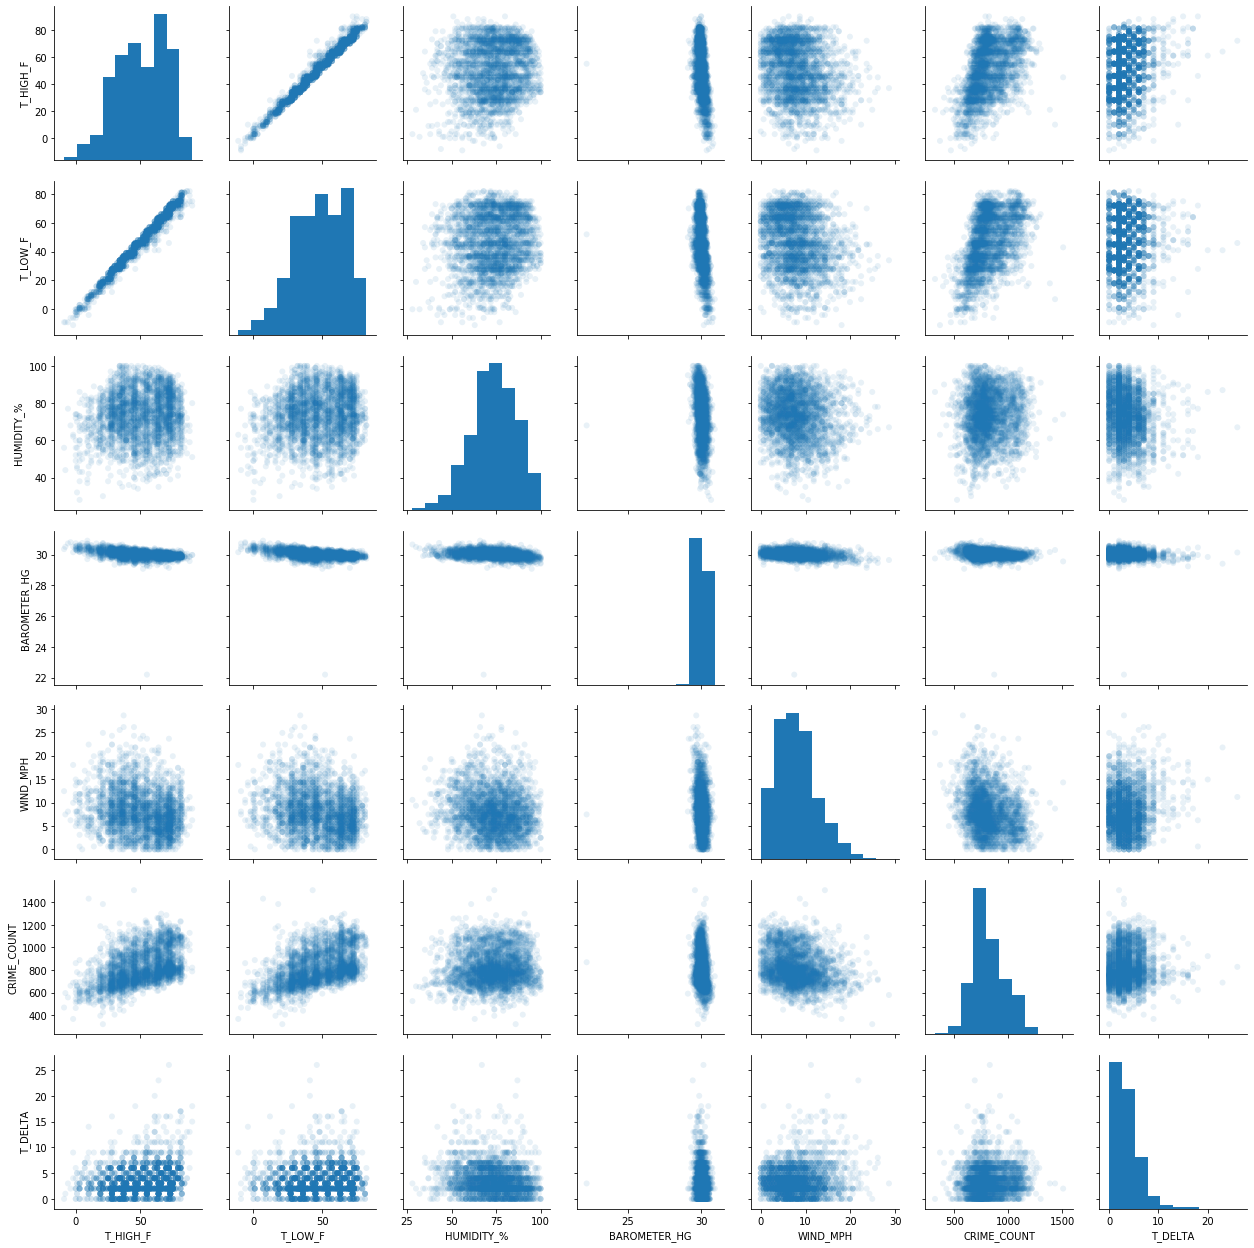

In [85]:
sns.pairplot(df_merged[list(df_merged.columns)[0:7]], plot_kws=dict(alpha=.1, edgecolor='none'))

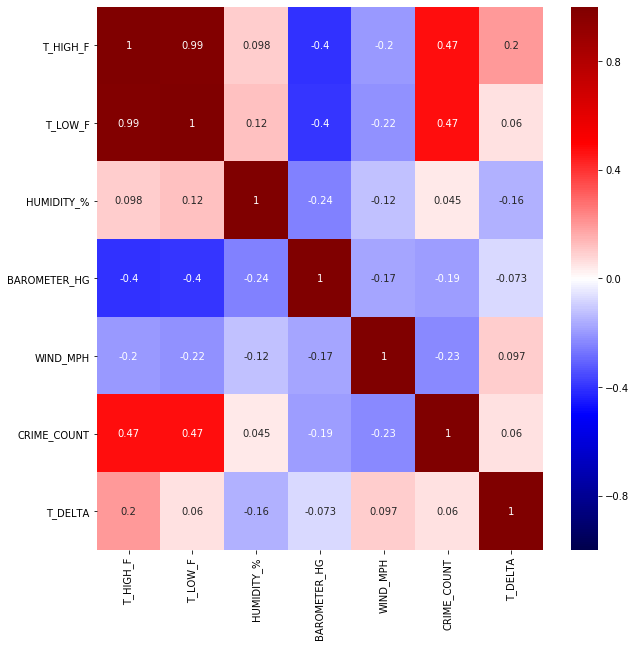

In [101]:
# corr matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df_merged[list(df_merged.columns)[0:7]].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

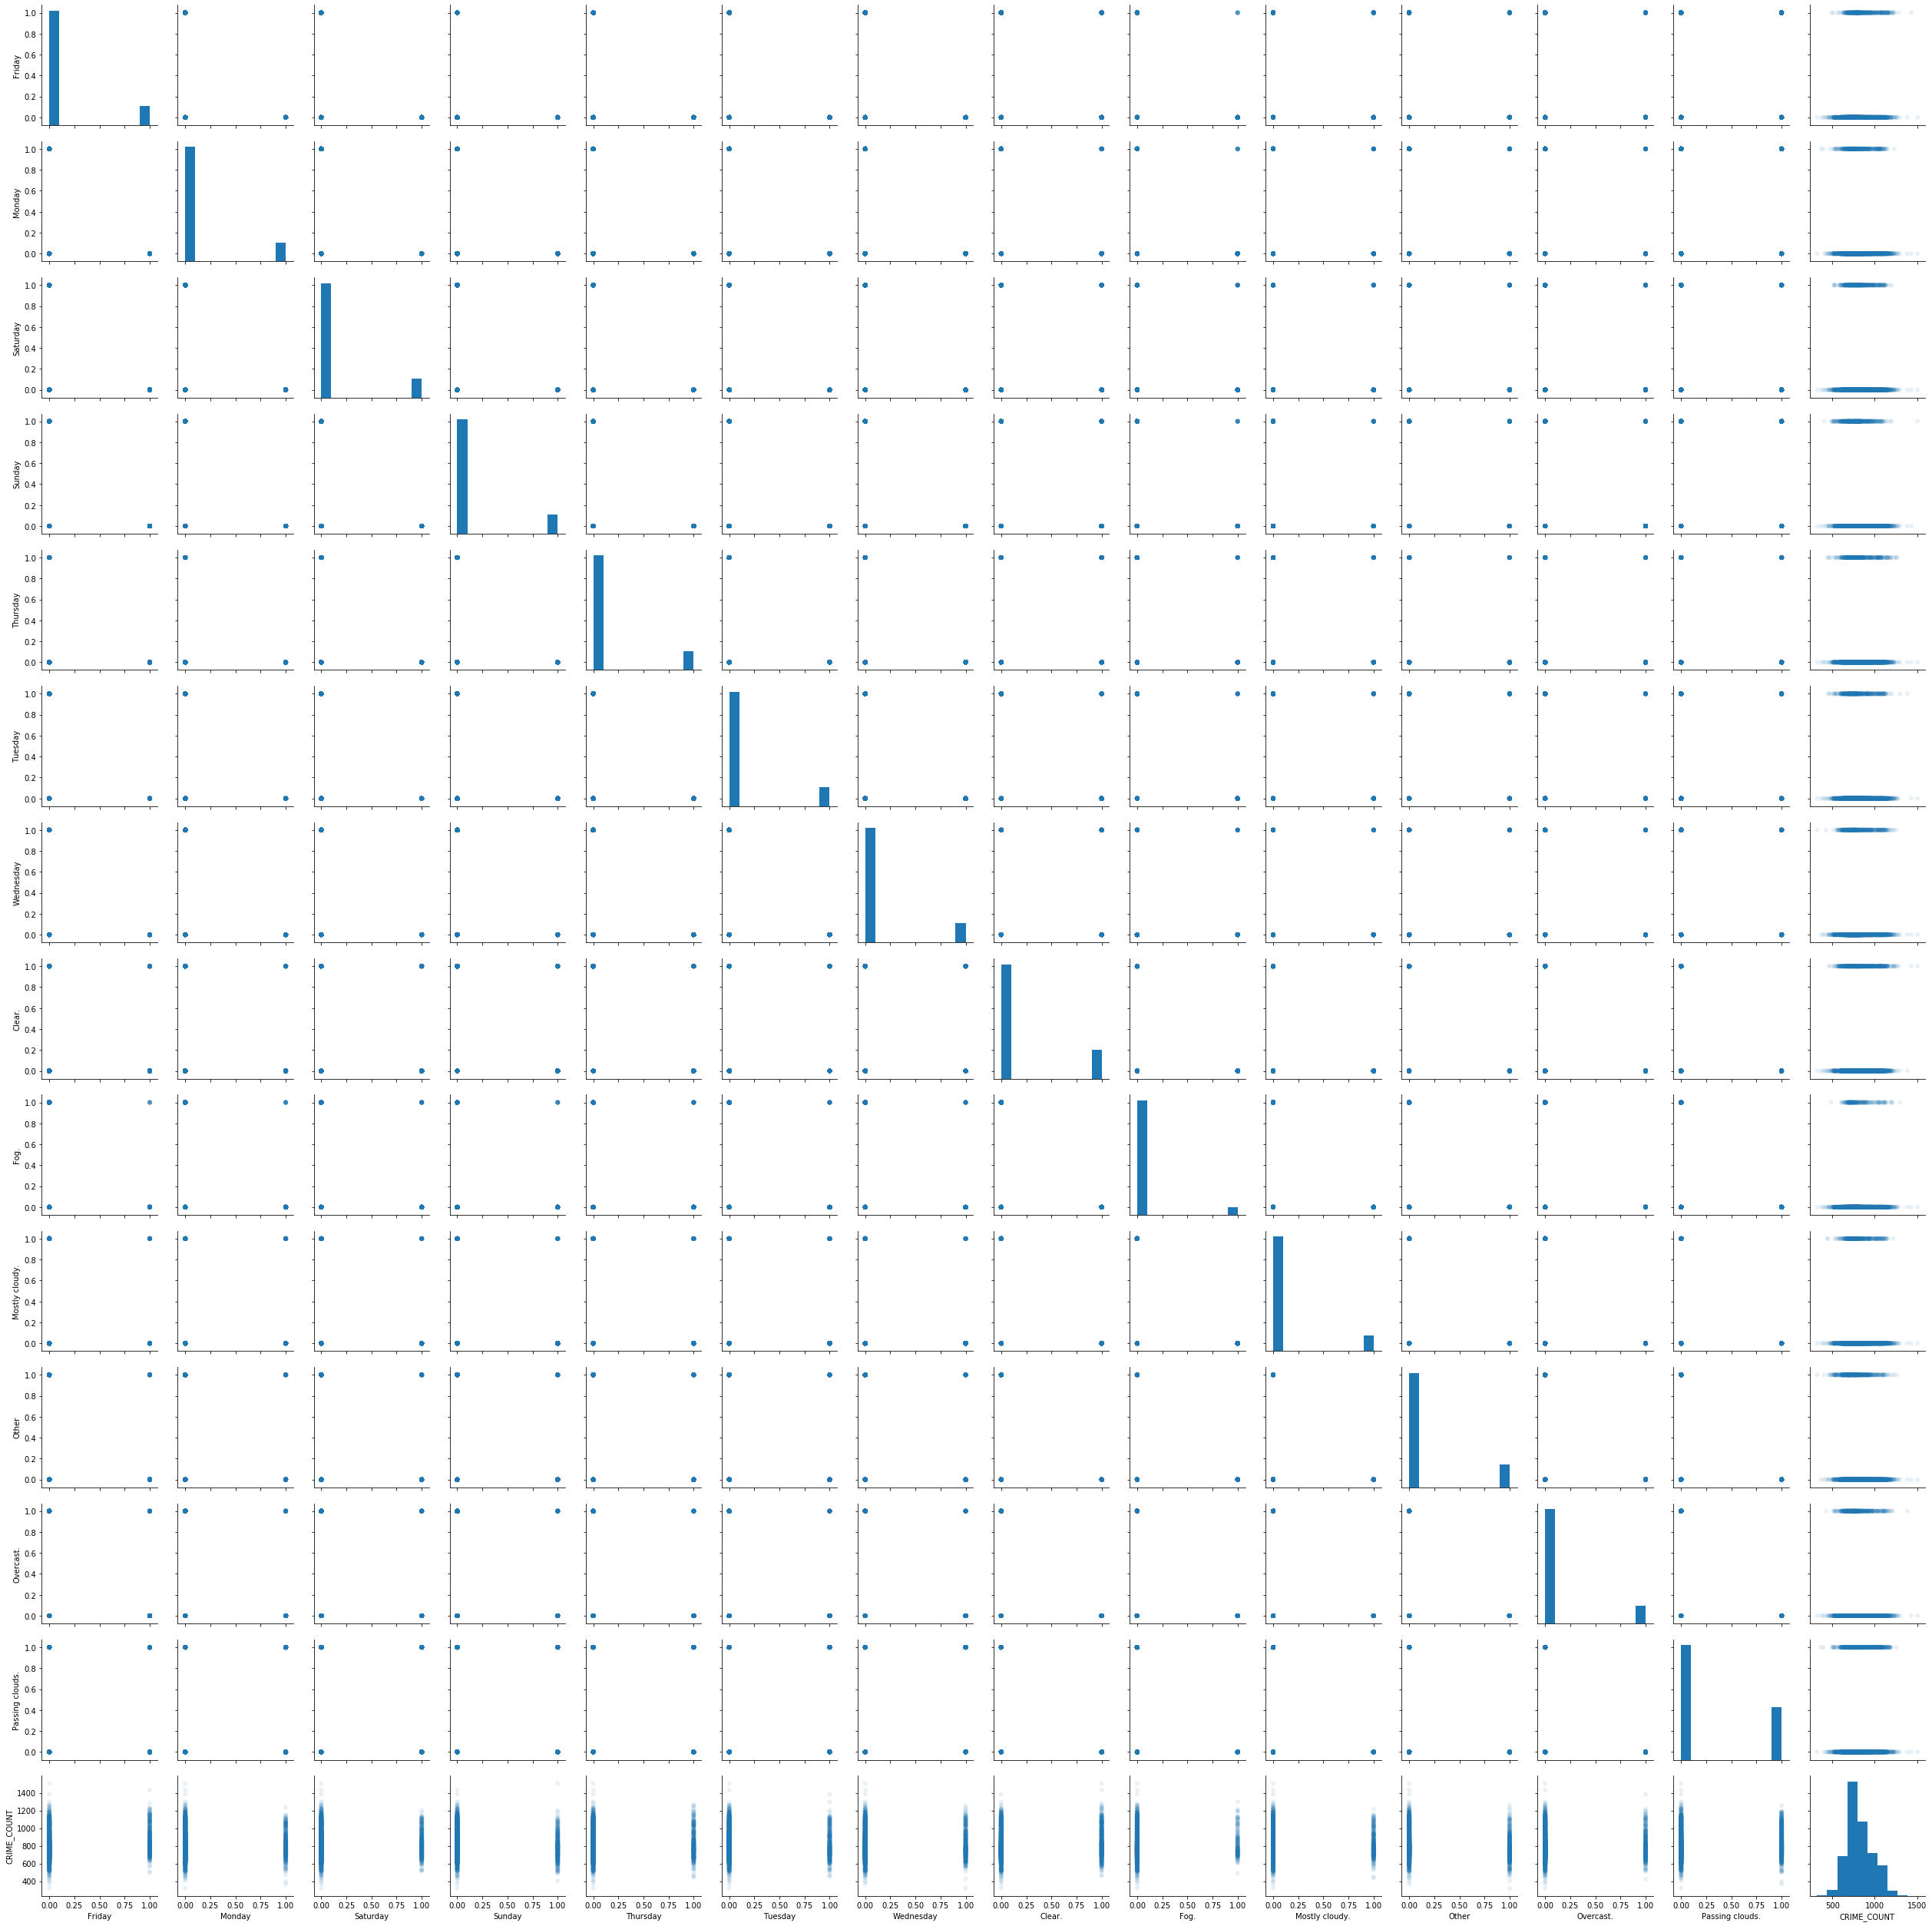

In [90]:
sns.pairplot(pd.concat([df_merged[list(df_merged.columns)[7:]], df_merged['CRIME_COUNT']], axis=1), plot_kws=dict(alpha=.1, edgecolor='none'))

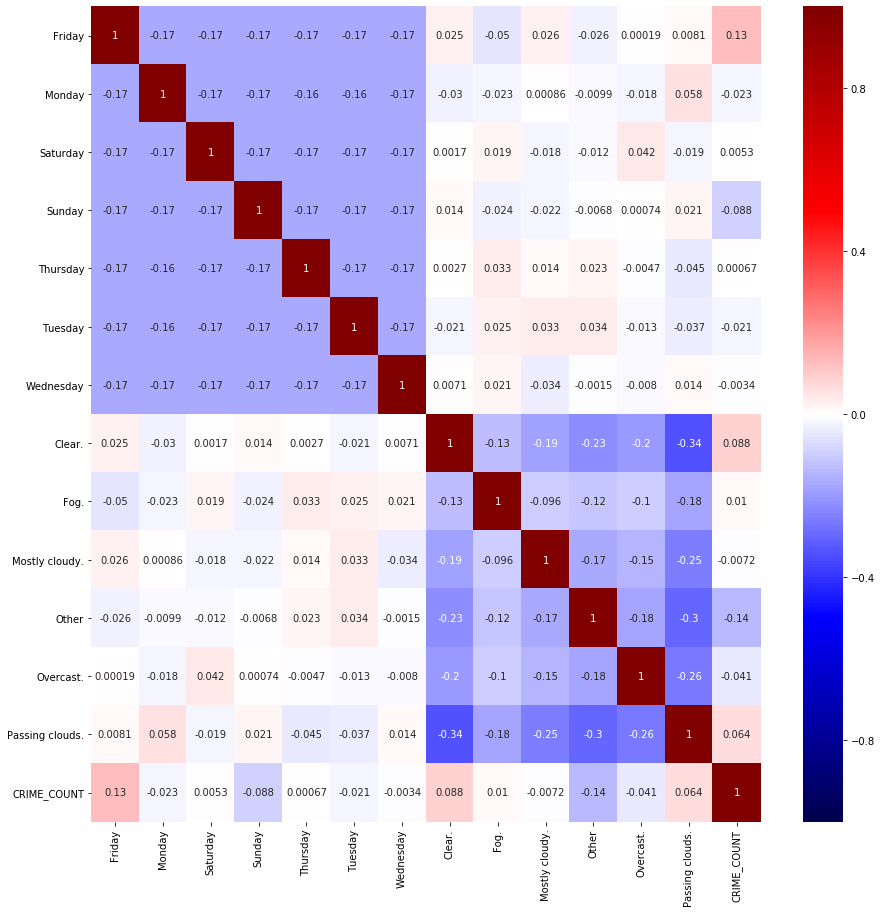

In [98]:
# corr matrix
plt.figure(figsize=(15, 15))
sns.heatmap(pd.concat([df_merged[list(df_merged.columns)[7:]], df_merged['CRIME_COUNT']], axis=1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

In [ ]:
# df_merged['WEATHER_DESC'].describe()
# df_merged['WEATHER_DESC'].unique()
# df_merged['WIND_DIRECTION'].describe()
# df_merged['WIND_DIRECTION'].unique()
# df_merged['DAY_NAME'].describe()

In [ ]:


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)